### Step 1: Data Preprocessing

#### Load Metadata and Annotations


In [55]:
import pandas as pd

# Define file paths
metadata_file = '../dataset//development_scenes.csv'
annotations_file = '../dataset/development_scene_annotations.csv'

# Load the CSV files
metadata = pd.read_csv(metadata_file)
annotations = pd.read_csv(annotations_file)

print("Metadata:")
print(metadata.head())
print("\nAnnotations:")
print(annotations.head())


Metadata:
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132

Annotations:
                        filename         command     start       end
0         2_speech_true_Ofen_aus        Ofen aus  11.25230  12.07747
1         3_speech_true_Radio_an  Staubsauger an  21.48040  23.18083
2         4_speech_true_Alarm_an        Alarm an  14.45720  16.08301
3        9_speech_true_Radio_aus  Staubsauger an   3.67909   5.63126
4  11_speech_false_Fernseher_aus  Staubsauger an  10.57850  11.67886


#### Preprocess Audio Files (WAV) and Perform ICA


In [56]:
import os
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import numpy as np

# Define directories
scenes_dir = '../dataset/scenes/wav'  # Update this path

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    scaler = StandardScaler()
    audio = scaler.fit_transform(audio.reshape(-1, 1)).flatten()
    
    ica = FastICA(n_components=1, whiten='unit-variance')
    audio = ica.fit_transform(audio.reshape(-1, 1)).flatten()
    
    return audio, sr

# Function to segment audio based on annotations
def segment_audio(audio, sr, start, end):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return audio[start_sample:end_sample]

# Preprocess and segment all audio files
preprocessed_segments = []

for idx, row in annotations.iterrows():
    file_name = row['filename']
    command = row['command']
    start = row['start']
    end = row['end']
    
    file_path = os.path.join(scenes_dir, file_name + '.wav')
    
    try:
        audio, sr = load_and_preprocess_audio(file_path)
        segment = segment_audio(audio, sr, start, end)
        preprocessed_segments.append((file_name, command, segment, sr))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example: display the first segment
print(f"First segment: {preprocessed_segments[0]}")


First segment: ('2_speech_true_Ofen_aus', 'Ofen aus', array([-0.08628684, -0.07286587, -0.07549172, ..., -0.42793807,
       -0.432898  , -0.45507178], dtype=float32), 16000)


### Step 2: Data Augmentation

#### Apply Data Augmentation


In [57]:
import librosa
import numpy as np

# Function to augment audio
def augment_audio(audio, sr):
    augmented = []
    # Original length
    original_length = len(audio)
    
    # Shift
    shift = int(sr * 0.5)  # shift by 0.5 seconds
    shifted_audio = np.roll(audio, shift)
    augmented.append(shifted_audio)
    
    # Stretch
    stretch = librosa.effects.time_stretch(audio, rate=0.8)
    if len(stretch) < original_length:
        # Pad with zeros if stretched audio is shorter
        stretch = np.pad(stretch, (0, original_length - len(stretch)), mode='constant')
    else:
        stretch = stretch[:original_length]  # ensure same length
    augmented.append(stretch)
    
    # Debug information
    for aug_audio in augmented:
        print(f"Original length: {original_length}, Augmented length: {len(aug_audio)}")
        if len(aug_audio) < 2048:
            print(f"Warning: Augmented segment length {len(aug_audio)} is shorter than n_fft=2048")
    
    return augmented

# Apply augmentation to all segments
augmented_segments = []
for file_name, command, segment, sr in preprocessed_segments:
    augmented = augment_audio(segment, sr)
    for aug in augmented:
        augmented_segments.append((file_name, command, aug, sr))

# Combine original and augmented data
all_segments = preprocessed_segments + augmented_segments


Original length: 13203, Augmented length: 13203
Original length: 13203, Augmented length: 13203
Original length: 27207, Augmented length: 27207
Original length: 27207, Augmented length: 27207
Original length: 26013, Augmented length: 26013
Original length: 26013, Augmented length: 26013
Original length: 31235, Augmented length: 31235
Original length: 31235, Augmented length: 31235
Original length: 17605, Augmented length: 17605
Original length: 17605, Augmented length: 17605
Original length: 29227, Augmented length: 29227
Original length: 29227, Augmented length: 29227
Original length: 18003, Augmented length: 18003
Original length: 18003, Augmented length: 18003
Original length: 16013, Augmented length: 16013
Original length: 16013, Augmented length: 16013
Original length: 26006, Augmented length: 26006
Original length: 26006, Augmented length: 26006
Original length: 23623, Augmented length: 23623
Original length: 23623, Augmented length: 23623
Original length: 23210, Augmented length

/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Original length: 19993, Augmented length: 19993
Original length: 19993, Augmented length: 19993
Original length: 22393, Augmented length: 22393
Original length: 22393, Augmented length: 22393
Original length: 16415, Augmented length: 16415
Original length: 16415, Augmented length: 16415
Original length: 10810, Augmented length: 10810
Original length: 10810, Augmented length: 10810
Original length: 23603, Augmented length: 23603
Original length: 23603, Augmented length: 23603
Original length: 21198, Augmented length: 21198
Original length: 21198, Augmented length: 21198
Original length: 20835, Augmented length: 20835
Original length: 20835, Augmented length: 20835
Original length: 20796, Augmented length: 20796
Original length: 20796, Augmented length: 20796
Original length: 39603, Augmented length: 39603
Original length: 39603, Augmented length: 39603
Original length: 32048, Augmented length: 32048
Original length: 32048, Augmented length: 32048
Original length: 19195, Augmented length

### Step 3: Feature Extraction

#### Extract Features with Padding/Truncation and Dynamic `n_fft`


In [58]:
# Function to extract features with dynamic n_fft
def extract_features(segment, sr, max_length):
    n_fft = min(2048, max(256, len(segment) // 2))  # Ensure n_fft is not larger than half the segment length and at least 256
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    print(f"Extracting features with n_fft={n_fft} for segment length={len(segment)}")
    hop_length = n_fft // 4  # Typical value for hop_length
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfccs_flat = mfccs.flatten()
    if len(mfccs_flat) < max_length:
        # Pad with zeros
        padded_mfccs = np.pad(mfccs_flat, (0, max_length - len(mfccs_flat)), mode='constant')
        return padded_mfccs
    else:
        # Truncate to max_length
        return mfccs_flat[:max_length]

# Determine the maximum length for padding/truncation
max_length = 0
for _, _, segment, sr in all_segments:
    n_fft = min(2048, max(256, len(segment) // 2))
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    hop_length = n_fft // 4
    features = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length).flatten()
    if len(features) > max_length:
        max_length = len(features)

# Extract features for all segments with padding/truncation
feature_data = []
for file_name, command, segment, sr in all_segments:
    features = extract_features(segment, sr, max_length)
    feature_data.append((file_name, command, features))

print(f"Feature extraction completed with max length: {max_length}")


Extracting features with n_fft=2048 for segment length=13203
Extracting features with n_fft=2048 for segment length=27207
Extracting features with n_fft=2048 for segment length=26013
Extracting features with n_fft=2048 for segment length=31235
Extracting features with n_fft=2048 for segment length=17605
Extracting features with n_fft=2048 for segment length=29227
Extracting features with n_fft=2048 for segment length=18003
Extracting features with n_fft=2048 for segment length=16013
Extracting features with n_fft=2048 for segment length=26006
Extracting features with n_fft=2048 for segment length=23623
Extracting features with n_fft=2048 for segment length=23210
Extracting features with n_fft=2048 for segment length=13211
Extracting features with n_fft=2048 for segment length=14011
Extracting features with n_fft=2048 for segment length=20823
Extracting features with n_fft=2048 for segment length=16793
Extracting features with n_fft=2048 for segment length=20811
Extracting features with

### Step 4: Model Training and Evaluation

#### Train `GradientBoostingClassifier` with Class Weights and Progress Bar


In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Prepare data for training
X = np.array([features for _, _, features in feature_data])
y = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Print class weights for debugging
print("Class Weights: ", class_weight_dict)

# Create sample weights
sample_weights = np.array([class_weight_dict[cls] for cls in y_train])

# Print sample weights for debugging
print("Sample Weights: ", sample_weights)


Class Weights:  {0: 1.117132867132867, 1: 1.4522727272727274, 2: 1.1833333333333333, 3: 1.6136363636363635, 4: 1.1921641791044777, 5: 1.1921641791044777, 6: 1.1017241379310345, 7: 0.8363874345549738, 8: 1.3653846153846154, 9: 1.6136363636363635, 10: 1.5661764705882353, 11: 1.3094262295081966, 12: 1.353813559322034, 13: 1.2102272727272727, 14: 0.23736998514115898, 15: 1.5661764705882353}
Sample Weights:  [0.23736999 0.23736999 0.23736999 ... 1.21022727 1.19216418 1.30942623]


In [60]:
# Print class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution: ", class_distribution)


Class Distribution:  {0: 143, 1: 110, 2: 135, 3: 99, 4: 134, 5: 134, 6: 145, 7: 191, 8: 117, 9: 99, 10: 102, 11: 122, 12: 118, 13: 132, 14: 673, 15: 102}


In [61]:
# Train a Gradient Boosting classifier with a progress bar and sample weights
n_estimators = 100
gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42, warm_start=True)

# Wrap the training loop with tqdm for the progress bar
for i in tqdm(range(1, n_estimators + 1), desc="Training Gradient Boosting Classifier"):
    gb.n_estimators = i
    gb.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate the classifier
y_pred_gb = gb.predict(X_val)
print("Gradient Boosting Classifier Report")
print(classification_report(y_val, y_pred_gb, zero_division=0))


Training Gradient Boosting Classifier: 100%|██████████| 100/100 [10:38<00:00,  6.38s/it]

Gradient Boosting Classifier Report
              precision    recall  f1-score   support

           0       0.19      0.28      0.23        25
           1       0.32      0.29      0.31        31
           2       0.24      0.15      0.19        33
           3       0.28      0.21      0.24        24
           4       0.35      0.42      0.38        31
           5       0.11      0.14      0.12        28
           6       0.45      0.40      0.43        47
           7       0.39      0.62      0.48        40
           8       0.13      0.24      0.17        21
           9       0.47      0.23      0.31        30
          10       0.17      0.19      0.18        21
          11       0.12      0.12      0.12        25
          12       0.27      0.21      0.24        38
          13       0.11      0.19      0.14        27
          14       0.44      0.38      0.41       191
          15       0.44      0.26      0.33        27

    accuracy                           0.31 

#### Train `RandomForestClassifier` with Class Weights


In [62]:
# Train a Random Forest classifier with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf.fit(X_train, y_train)

# Evaluate the classifier
y_pred_rf = rf.predict(X_val)
print("Random Forest Classifier Report")
print(classification_report(y_val, y_pred_rf, zero_division=0))


Random Forest Classifier Report
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        25
           1       1.00      0.06      0.12        31
           2       1.00      0.03      0.06        33
           3       1.00      0.04      0.08        24
           4       0.50      0.03      0.06        31
           5       0.00      0.00      0.00        28
           6       0.60      0.19      0.29        47
           7       0.39      0.30      0.34        40
           8       1.00      0.05      0.09        21
           9       0.00      0.00      0.00        30
          10       0.00      0.00      0.00        21
          11       1.00      0.12      0.21        25
          12       0.50      0.03      0.05        38
          13       0.33      0.04      0.07        27
          14       0.33      0.96      0.49       191
          15       1.00      0.11      0.20        27

    accuracy                           0.35     

### Step 5: Ensemble Classifiers


Ensemble Classifier Report
              precision    recall  f1-score   support

           0       0.31      0.16      0.21        25
           1       0.33      0.10      0.15        31
           2       0.33      0.03      0.06        33
           3       0.29      0.08      0.13        24
           4       0.22      0.06      0.10        31
           5       0.50      0.07      0.12        28
           6       0.61      0.23      0.34        47
           7       0.48      0.38      0.42        40
           8       0.33      0.05      0.08        21
           9       0.25      0.03      0.06        30
          10       0.00      0.00      0.00        21
          11       0.20      0.08      0.11        25
          12       0.33      0.03      0.05        38
          13       0.40      0.15      0.22        27
          14       0.34      0.92      0.50       191
          15       1.00      0.07      0.14        27

    accuracy                           0.35       639

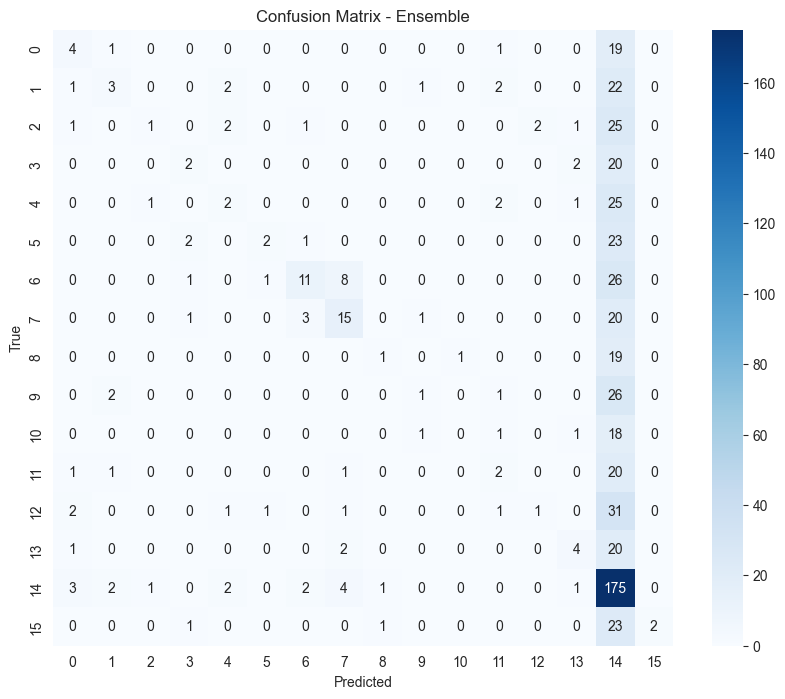

In [63]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and Gradient Boosting
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate the ensemble classifier
y_pred_ensemble = ensemble.predict(X_val)
print("Ensemble Classifier Report")
print(classification_report(y_val, y_pred_ensemble, zero_division=0))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = np.unique(y_val)
plot_confusion_matrix(y_val, y_pred_ensemble, labels, title='Confusion Matrix - Ensemble')


### Summary

We've consolidated the process into five clear steps:

1. **Data Preprocessing**: Load metadata and preprocess audio files with ICA.
2. **Data Augmentation**: Apply time-shifting and time-stretching to augment the audio data.
3. **Feature Extraction**: Extract MFCC features with appropriate padding/truncation and dynamic `n_fft`.
4. **Model Training and Evaluation**: Train `GradientBoostingClassifier` and `RandomForestClassifier`, handle class weights, and evaluate their performance.
5. **Ensemble Classifiers**: Combine predictions from multiple models to improve robustness.

Let's proceed with running these steps sequentially to ensure there are no errors, warnings, or obstacles. If you encounter any issues or need further adjustments, please let me know!

### Alternative ensembling method: Stacking

In [65]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_clf.predict(X_val)

# Evaluate the stacking classifier
print("Stacking Classifier Report")
print(classification_report(y_val, y_pred_stacking, zero_division=0))


KeyboardInterrupt: 

In [ ]:
class_weight_dict

### Step-by-Step Guide to Adding a CNN Classifier

1. **Define the CNN Architecture**: We'll use Keras with TensorFlow backend to define the CNN.
2. **Prepare Data for CNN**: Ensure the data is in the right shape and format for the CNN.
3. **Train the CNN**: Train the CNN on the training data.
4. **Evaluate the CNN**: Evaluate its performance on the validation data.
5. **Compare with Other Classifiers**: Compare the CNN's performance with the Gradient Boosting and Random Forest classifiers.

### Step 1: Define the CNN Architecture

We'll use a simple CNN architecture for this example.


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


2024-05-29 14:31:01.329074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 2: Prepare Data for CNN

Ensure the data is reshaped and formatted correctly for the CNN.


In [68]:
import math

# Convert the feature data to a numpy array
X_cnn = np.array([features for _, _, features in feature_data])
y_cnn = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
y_cnn_encoded = label_encoder.transform(y_cnn)

# Convert labels to categorical
y_cnn_categorical = to_categorical(y_cnn_encoded)

# Determine input shape for CNN
num_features = X_cnn.shape[1]
# Calculate the dimensions (height and width) such that height * width = num_features
# Here, we aim for the closest possible square dimensions
height = int(math.sqrt(num_features))
width = height
if height * width < num_features:
    width += 1

# Adjust the number of features to match the closest square dimensions
num_adjusted_features = height * width
X_cnn_adjusted = np.zeros((X_cnn.shape[0], num_adjusted_features))
X_cnn_adjusted[:, :num_features] = X_cnn

# Reshape to (num_samples, height, width, 1)
X_cnn_reshaped = X_cnn_adjusted.reshape(-1, height, width, 1)

# Split data into training and validation sets
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn_reshaped, y_cnn_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_cnn shape: {X_cnn.shape}")
print(f"X_cnn_adjusted shape: {X_cnn_adjusted.shape}")
print(f"X_cnn_reshaped shape: {X_cnn_reshaped.shape}")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_val_cnn shape: {X_val_cnn.shape}")


X_cnn shape: (3195, 1170)
X_cnn_adjusted shape: (3195, 1190)
X_cnn_reshaped shape: (3195, 34, 35, 1)
X_train_cnn shape: (2556, 34, 35, 1)
X_val_cnn shape: (639, 34, 35, 1)


### Step 3: Train the CNN


In [69]:
# Create the CNN model
input_shape = (height, width, 1)
num_classes = len(np.unique(y_train_cnn.argmax(axis=1)))
cnn_model = create_cnn_model(input_shape, num_classes)

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))


Epoch 1/10


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1906 - loss: 4.7728 - val_accuracy: 0.2973 - val_loss: 2.4855
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2714 - loss: 2.4240 - val_accuracy: 0.2973 - val_loss: 2.4275
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3315 - loss: 2.1785 - val_accuracy: 0.3052 - val_loss: 2.4024
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4291 - loss: 1.8079 - val_accuracy: 0.2989 - val_loss: 2.4085
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5669 - loss: 1.3997 - val_accuracy: 0.2817 - val_loss: 2.4370
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7231 - loss: 0.9277 - val_accuracy: 0.2958 - val_loss: 2.7561
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8401 - loss: 0.5867 - val_accuracy: 0.3333 - val_loss: 3.1134
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9177 - loss: 0.3141 - val_accuracy: 0.3099 - val_loss: 3.

### Step 4: Evaluate the CNN


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 3.6247
CNN Model Accuracy: 0.32081377506256104
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
CNN Classifier Report
              precision    recall  f1-score   support

           0       0.23      0.24      0.24        25
           1       0.37      0.32      0.34        31
           2       0.17      0.18      0.17        33
           3       0.17      0.21      0.19        24
           4       0.16      0.26      0.20        31
           5       0.17      0.21      0.19        28
           6       0.41      0.28      0.33        47
           7       0.32      0.33      0.32        40
           8       0.17      0.19      0.18        21
           9       0.30      0.10      0.15        30
          10       0.12      0.10      0.11        21
          11       0.28      0.20      0.23        25
          12       0.23      0.08      0.12        38
          13       0.30      0.22      0.26        27
          14   

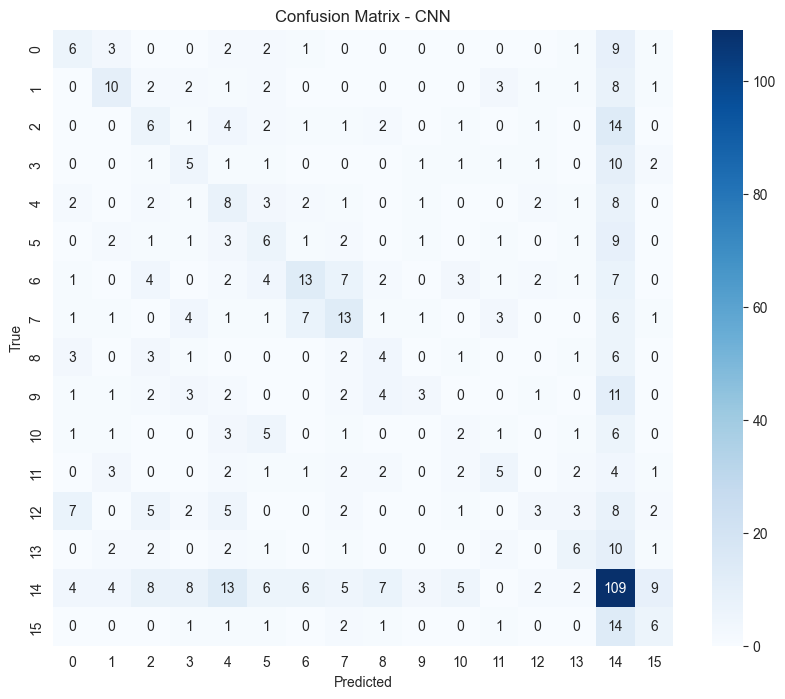

In [70]:
# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(X_val_cnn, y_val_cnn)
print(f"CNN Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = cnn_model.predict(X_val_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_cnn_classes = np.argmax(y_val_cnn, axis=1)

# Print classification report
print("CNN Classifier Report")
print(classification_report(y_val_cnn_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for CNN
plot_confusion_matrix(y_val_cnn_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - CNN')


### Step 5: Compare with Other Classifiers

You already have the evaluation metrics for the Gradient Boosting and Random Forest classifiers. Now you can compare the performance of the CNN with these classifiers.

### Summary

1. **Define CNN Architecture**: Use Keras to define a simple CNN.
2. **Prepare Data**: Reshape the feature data and convert labels to categorical format.
3. **Train CNN**: Train the CNN model on the training data.
4. **Evaluate CNN**: Evaluate the CNN's performance and compare it with other classifiers.

Run the above code step-by-step and compare the results. Let me know if you encounter any issues or need further adjustments!